<a href="https://colab.research.google.com/github/chaewoncutie/Trippings-practice-ig/blob/main/try%20code%20w%20decent%20silhoeutte%20scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages
!pip install -U scikit-learn nltk pandas matplotlib seaborn scipy wordcloud ipywidgets umap-learn hdbscan tensorflow keras

In [2]:
# Import necessary libraries
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import numpy as np
from collections import Counter
import umap
import hdbscan
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from IPython.display import display
from google.colab import files

In [3]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
# Upload the JSON file
uploaded = files.upload()

# Read the JSON file
df = pd.read_json(next(iter(uploaded)), lines=True)

# Display the first few rows of the dataframe
df.head()

Saving News_Category_Dataset_v3.json to News_Category_Dataset_v3 (2).json


link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

In [5]:
# Limit Dataset Size for Faster Processing
df = df.sample(n=50000, random_state=42)

# Keep relevant columns
df = df[['headline', 'short_description']].dropna()
df['text'] = df['headline'] + " " + df['short_description']

# Preprocessing Function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [6]:
# Tokenize and remove stopwords
stop_words = set(stopwords.words('english'))
df['filtered_text'] = df['processed_text'].apply(lambda text: ' '.join([word for word in word_tokenize(text) if word not in stop_words]))

In [7]:
# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['filtered_text'])

In [8]:
# Apply TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=50)
X_svd = svd.fit_transform(X)

In [9]:
# Apply UMAP for non-linear dimensionality reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42)
X_umap = umap_model.fit_transform(X_svd)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
# Normalize the data
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X_umap)

In [11]:
# Find the best k using silhouette score and elbow method
silhouette_scores = []
inertia_values = []
K = range(5, 40)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_normalized)
    sil_score = silhouette_score(X_normalized, kmeans_labels)
    inertia = kmeans.inertia_
    silhouette_scores.append(sil_score)
    inertia_values.append(inertia)
    print(f"k={k}, silhouette score={sil_score}, inertia={inertia}")

k=5, silhouette score=0.60652095079422, inertia=1382.4935302734375
k=6, silhouette score=0.5981987714767456, inertia=946.5496215820312
k=7, silhouette score=0.5829724073410034, inertia=721.4471435546875
k=8, silhouette score=0.561792254447937, inertia=544.8934936523438
k=9, silhouette score=0.5654218196868896, inertia=432.7384033203125
k=10, silhouette score=0.5608240365982056, inertia=358.4555969238281
k=11, silhouette score=0.5598366260528564, inertia=311.4049377441406
k=12, silhouette score=0.562362790107727, inertia=263.4056396484375
k=13, silhouette score=0.573479950428009, inertia=224.07333374023438
k=14, silhouette score=0.5528990030288696, inertia=191.56004333496094
k=15, silhouette score=0.5524512529373169, inertia=167.9179229736328
k=16, silhouette score=0.5557072162628174, inertia=147.42269897460938
k=17, silhouette score=0.5622252225875854, inertia=130.3665771484375
k=18, silhouette score=0.5621740818023682, inertia=117.58932495117188
k=19, silhouette score=0.56116598844528

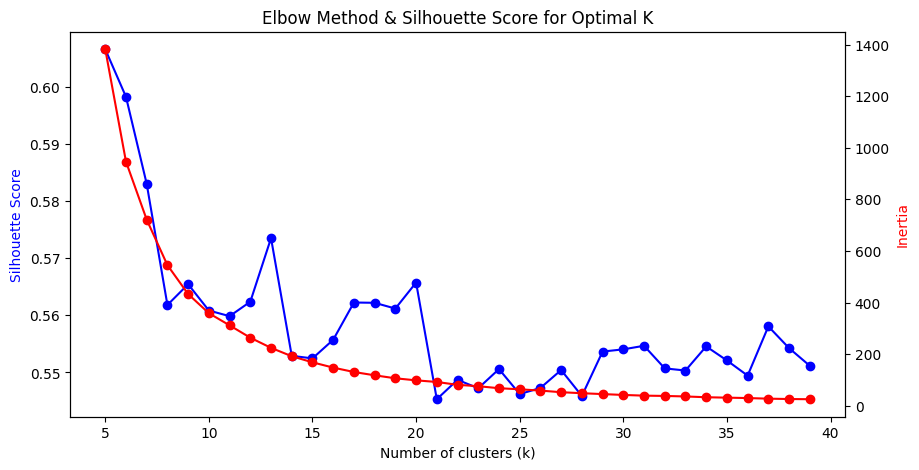

In [12]:
# Plot silhouette scores and inertia
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(K, silhouette_scores, 'bo-', label='Silhouette Score')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Silhouette Score', color='blue')
ax2 = ax1.twinx()
ax2.plot(K, inertia_values, 'ro-', label='Inertia')
ax2.set_ylabel('Inertia', color='red')
plt.title('Elbow Method & Silhouette Score for Optimal K')
plt.show()

In [13]:
# Apply optimized KMeans clustering
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_normalized)
df['cluster_kmeans'] = kmeans_labels

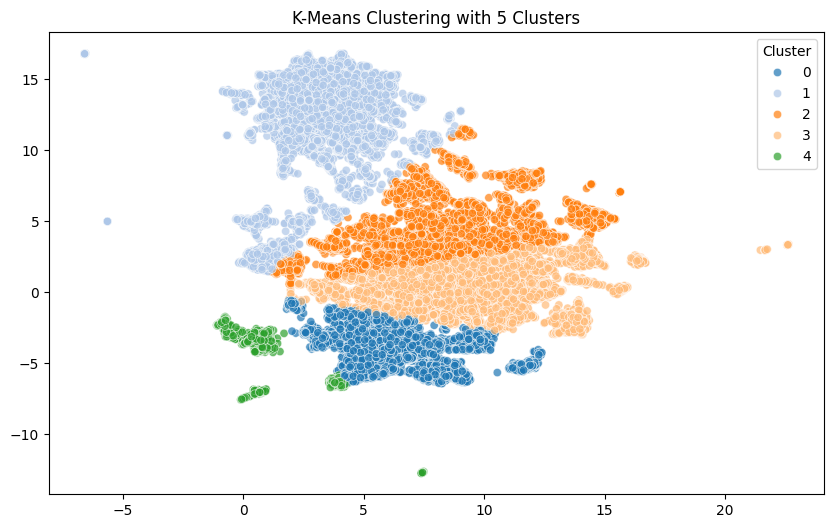

In [14]:
# Plot KMeans Clustering Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df['cluster_kmeans'], palette='tab20', alpha=0.7)
plt.title(f"K-Means Clustering with {optimal_k} Clusters")
plt.legend(title="Cluster")
plt.show()

In [15]:
# Apply HDBSCAN clustering with optimized settings
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, min_samples=30, metric='euclidean')
hdb_labels = clusterer.fit_predict(X_normalized)
df['cluster_hdbscan'] = hdb_labels
print("HDBSCAN clustering completed.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN clustering completed.


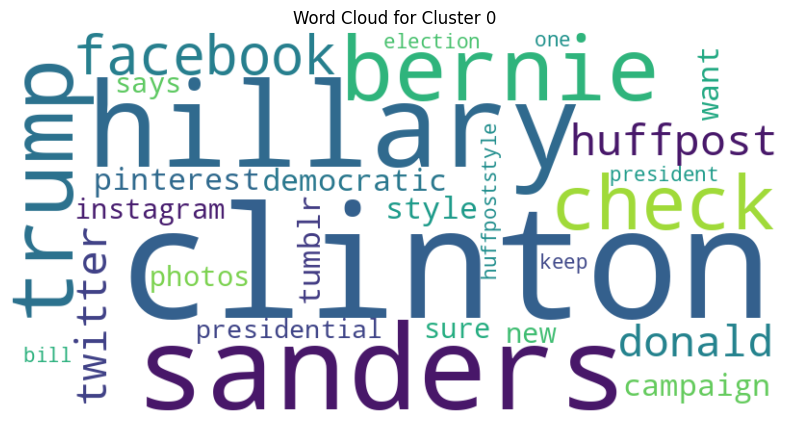

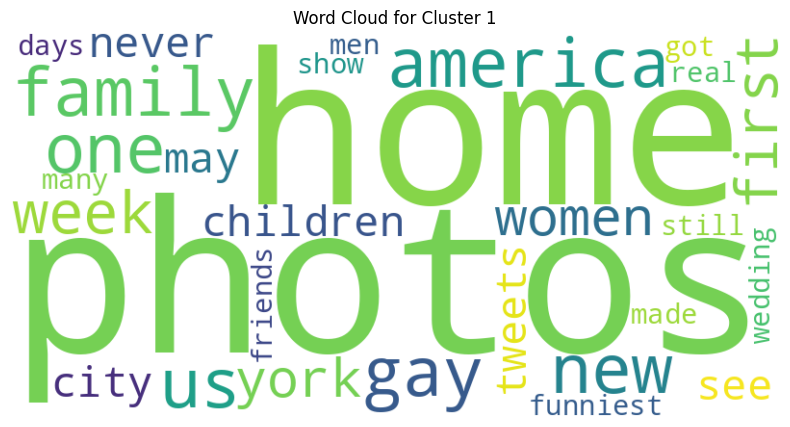

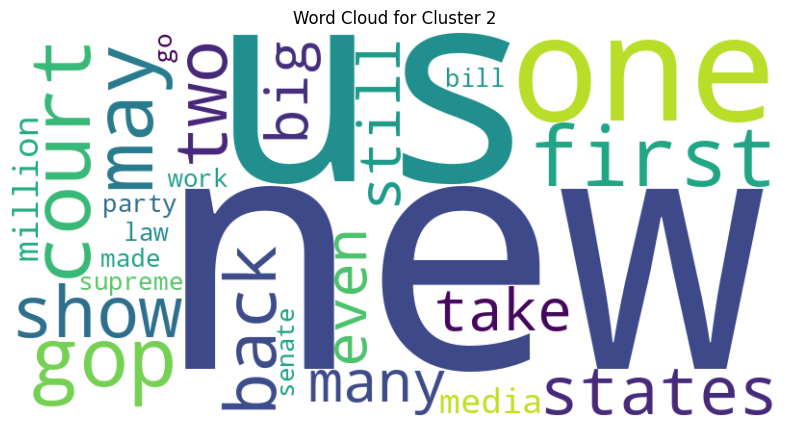

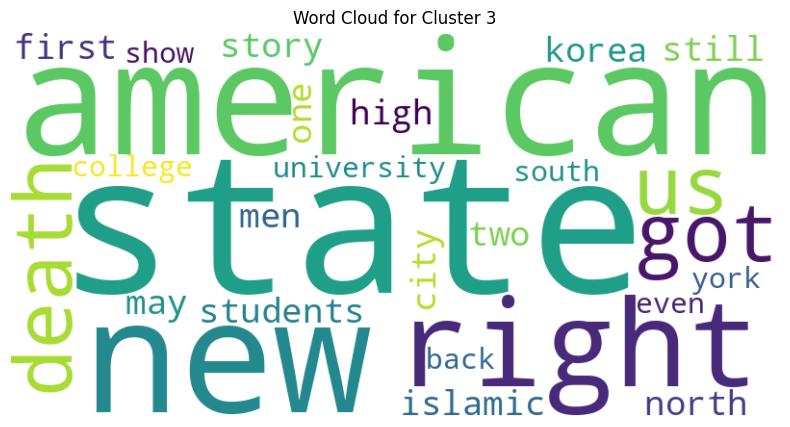

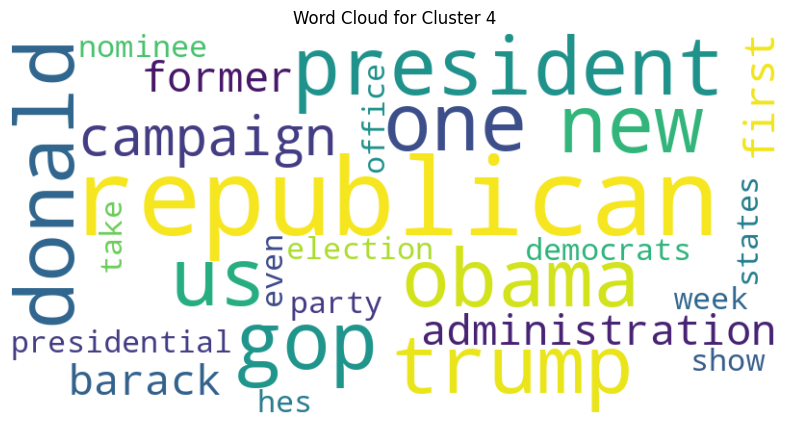

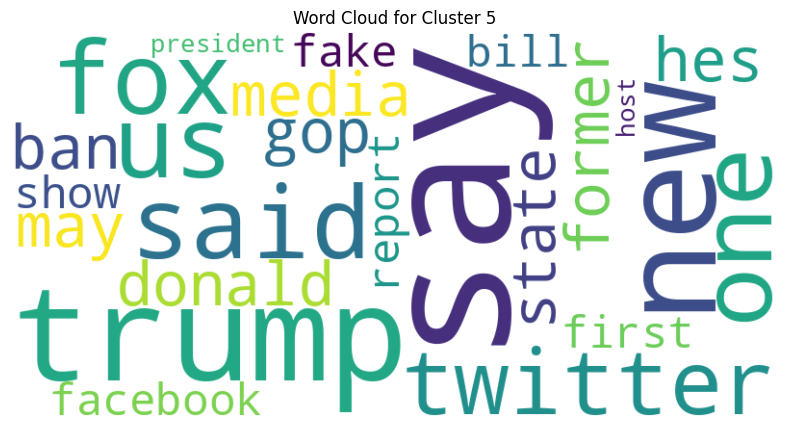

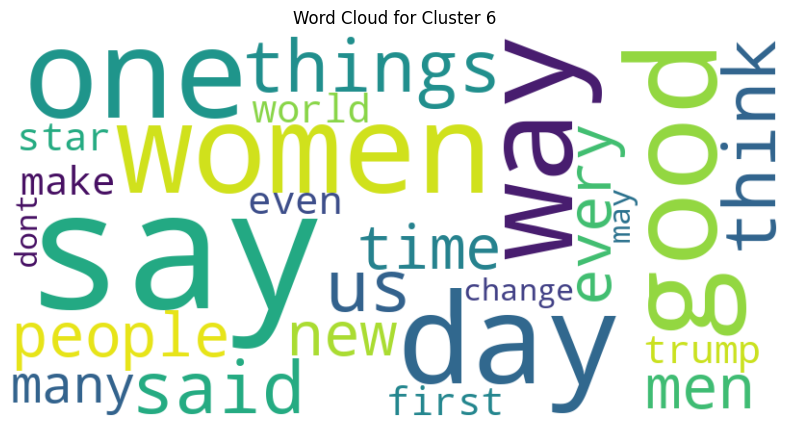

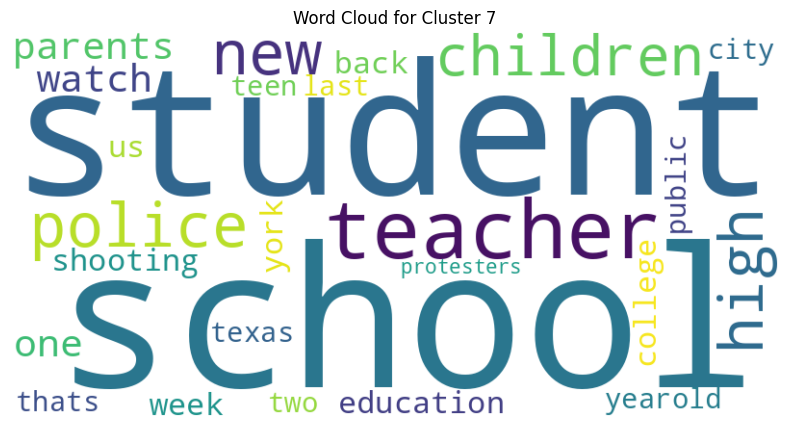

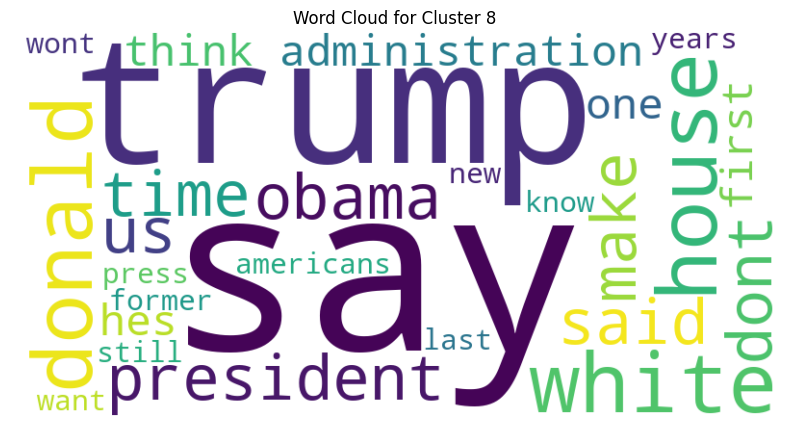

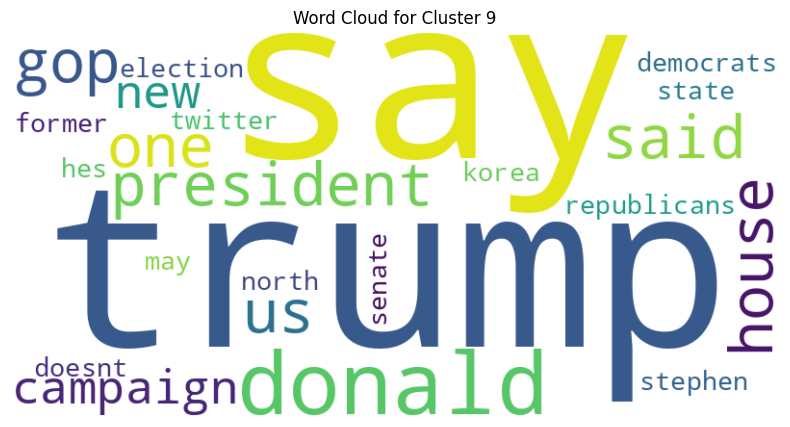

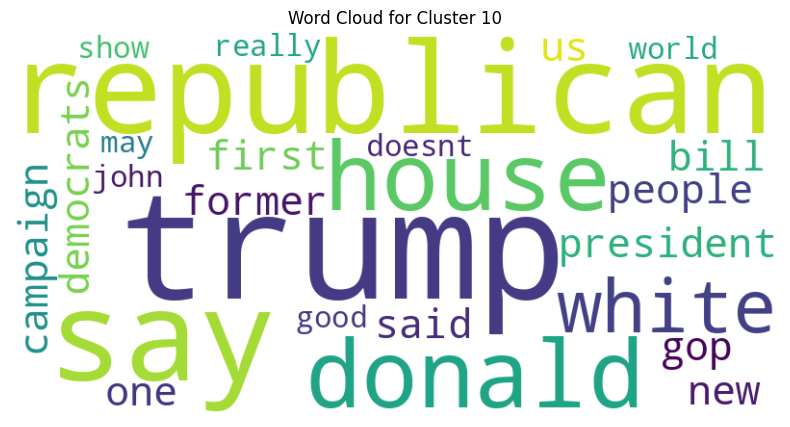

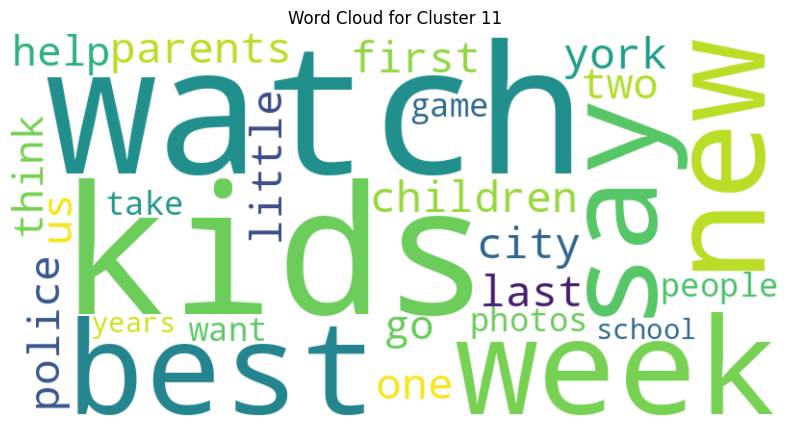

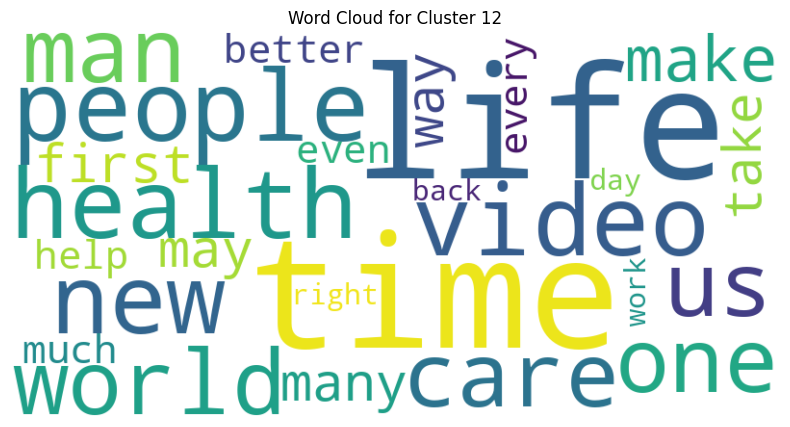

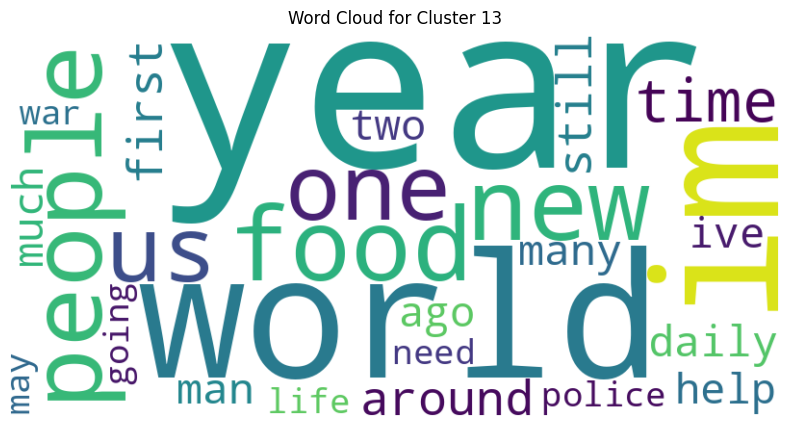

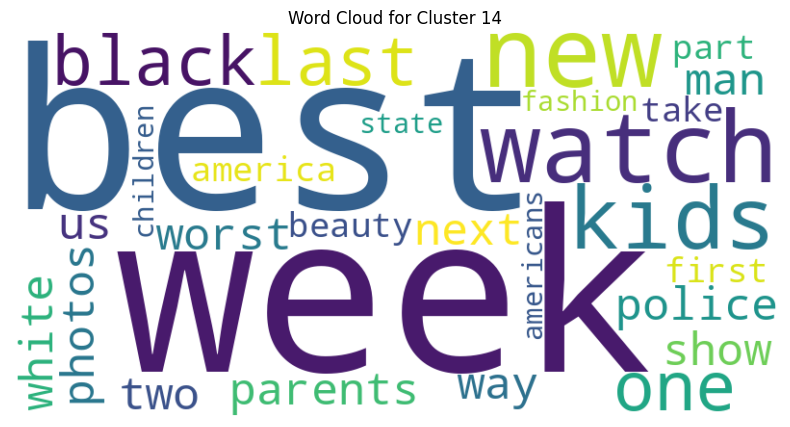

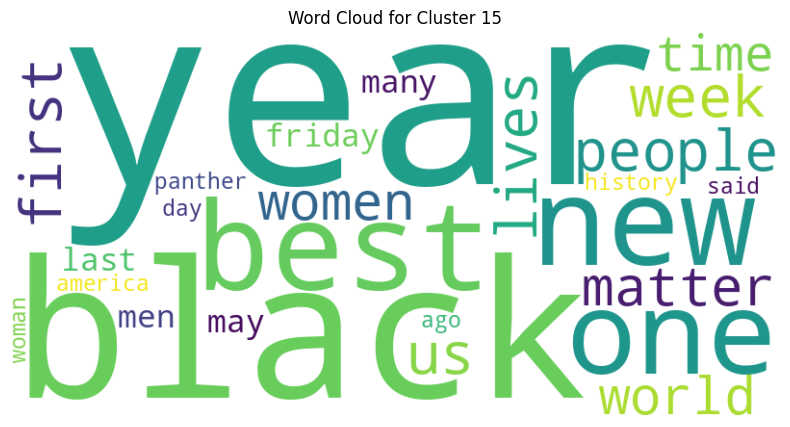

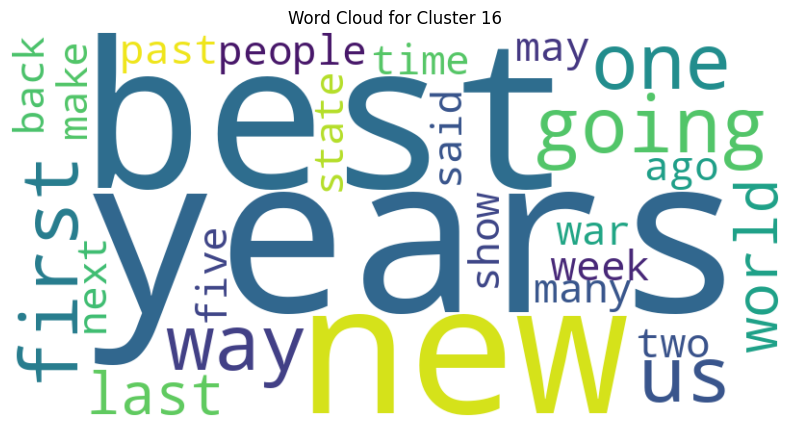

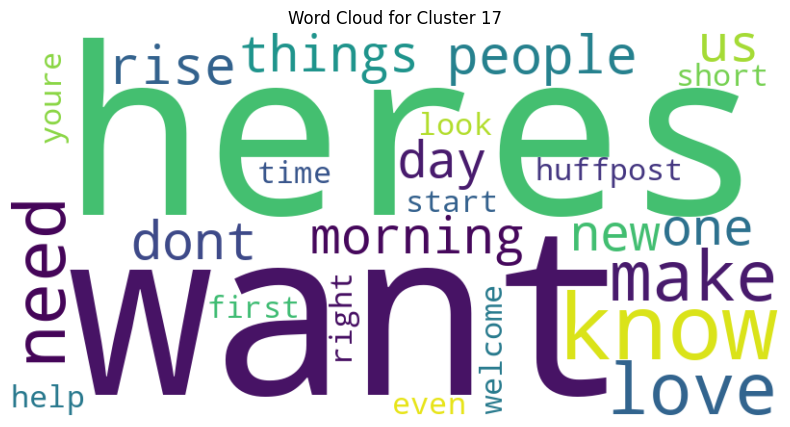

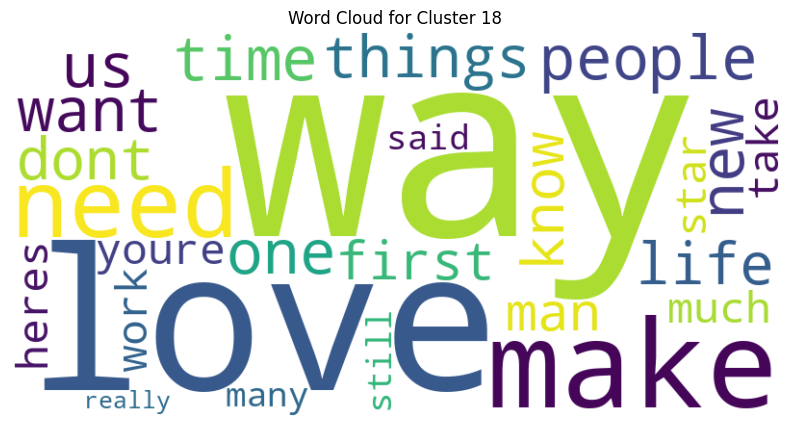

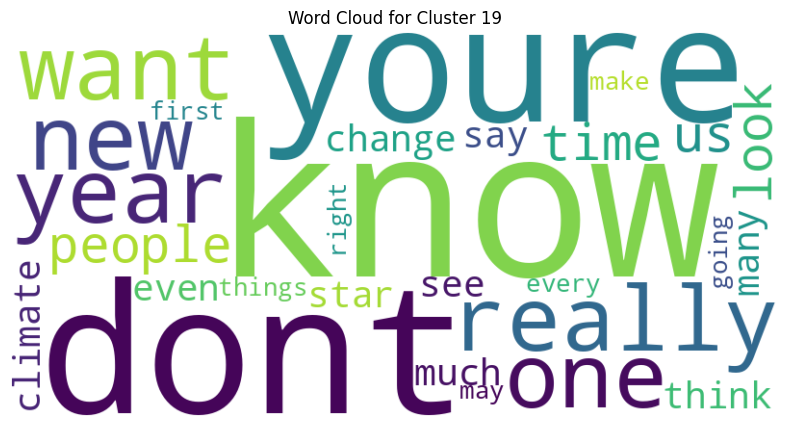

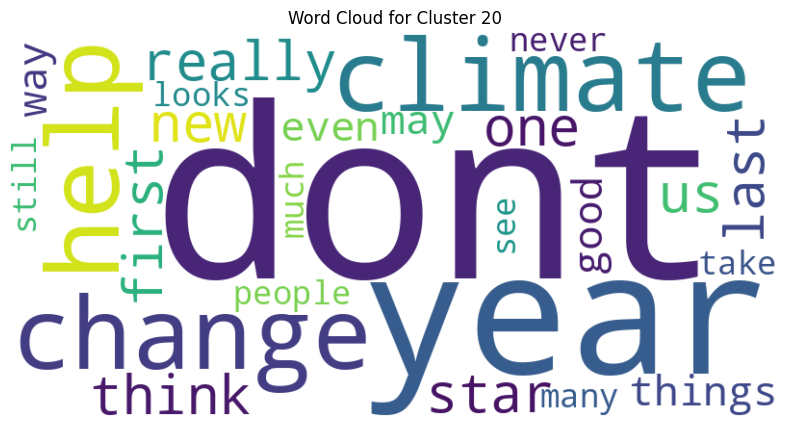

In [16]:
# Generate word cloud for each cluster
for cluster in set(hdb_labels):
    if cluster == -1:
        continue  # Ignore noise points
    cluster_texts = ' '.join(df.loc[df['cluster_hdbscan'] == cluster, 'filtered_text'])
    most_common_words = Counter(cluster_texts.split()).most_common(30)
    wordcloud_text = ' '.join([word for word, _ in most_common_words])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

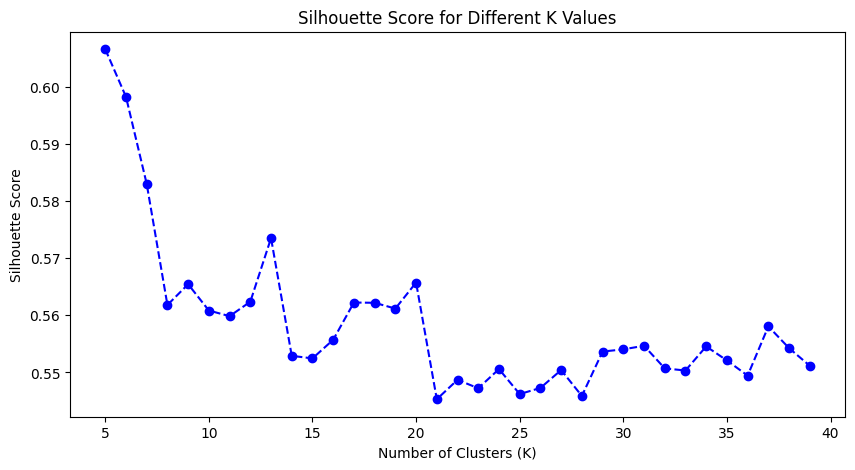

Clustering process completed.


In [18]:
# Generate a silhouette score plot
plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K Values")
plt.show()

print("Clustering process completed.")